# Preprocessing of USPTO (Reaxys formatted)

In [302]:
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import numpy as np
from tqdm import tqdm
from tqdm import trange
# import pyarrow as pa

In [303]:
"""
Disables RDKit whiny logging.
"""
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')


In [304]:
USPTO_elsevier = pd.read_csv('data/USPTO_from_reaxys/uspto_1k_TPL_train_valid.tsv', sep='\t')
USPTO_elsevier.columns

Index(['Unnamed: 0', 'level_0', 'index', 'original_rxn', 'fragments', 'source',
       'year', 'mapped_rxn', 'confidence', 'canonical_rxn_with_fragment_info',
       'canonical_rxn', 'ID', 'reaction_hash', 'reactants', 'products',
       'retro_template', 'template_hash', 'selectivity', 'outcomes',
       'reagents', 'labels'],
      dtype='object')

In [305]:
USPTO_elsevier = USPTO_elsevier.iloc[:10000]

In [306]:
# create lists for reactants and other stuff
reactant1_list = []
reactant2_list = []

product_list = [] #there's only ever 1 product

reagent1_list = []
reagent2_list = []

other_list = []

for i in range(len(USPTO_elsevier)):
    #handle reactants first
    reactant1 = None
    reactant2 = None
    other = []
    reactants = USPTO_elsevier['reactants'][i].split('.')
    for molecule in reactants:
        if '[' in molecule: #its a reactant
            if not reactant1:
                reactant1 = molecule
            elif not reactant2:
                reactant2 = molecule
            else:
                other +=[molecule]
        else:
            other +=[molecule]

    #then reagents
    reagent1 = None
    reagent2 = None
    reagents = USPTO_elsevier['reagents'][i]
    if reagents == reagents:
        reagents = reagents.split('.')
        for molecule in reagents:
            #populate the first two variables with reagents, add everything else to 'other'
            if 'Pd' in molecule:
                other += [molecule]
            else: 
                if not reagent1:
                    reagent1 = molecule
                elif not reagent2:
                    reagent2 = molecule
                else:
                    other +=[molecule]

    reactant1_list += [reactant1]
    reactant2_list += [reactant2]
    product_list += [USPTO_elsevier['products'][i]]
    reagent1_list += [reagent1]
    reagent2_list += [reagent2]
    other_list += [other]
del USPTO_elsevier

# Read in USPTO data from ORD format (pickled data)

In [307]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm import tqdm

In [308]:
# mypath = 'data/ORD_USPTO/pickled_data/'
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [309]:
# #create one big df of all the pickled data
# full_df = pd.DataFrame()
# for file in tqdm(onlyfiles):
#     if file[0] != '.': #We don't want to try to unpickle .DS_Store
#         filepath = mypath+file 
#         unpickled_df = pd.read_pickle(filepath)
#         full_df = pd.concat([full_df, unpickled_df], ignore_index=True)


In [310]:
# full_df

# Calculate FP

In [311]:
def calc_fp(lst, radius, nBits):
    ans = []
    for i in tqdm(lst):
        #convert to mole object
        try:
            mol = Chem.MolFromSmiles(i)
            fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits=nBits)
            array = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, array)
            ans += [array]
        except:
            ans += [np.zeros((nBits,), dtype=int)]
    return ans

In [312]:
# calculate fingerprints
radius = 3
nBits = 1024

In [313]:
reactant1_list_fp = calc_fp(reactant1_list, radius, nBits)

100%|██████████| 10000/10000 [00:02<00:00, 4484.25it/s]


In [314]:
from collections import Counter
counter_obj = Counter(reactant1_list)

In [315]:
counter_obj

Counter({'O[C:54](=[O:55])[CH2:56][NH:57][C:58](=[O:59])[CH2:60][NH:61][C:62](=[O:63])[O:64][C:65]([CH3:66])([CH3:67])[CH3:68]': 1,
         '[Pd]': 57,
         'Cl[S:43]([CH3:44])(=[O:45])=[O:46]': 1,
         'O[C:16](=[O:17])[C@H:18]([CH2:19][C@H:20]1[CH2:21][CH2:22][C:23](=[O:24])[CH2:25]1)[c:26]1[cH:27][cH:28][cH:29][c:30]([C:31]([F:32])([F:33])[F:34])[cH:35]1': 1,
         'C[Si](C)(C)C=[N+]=[N-]': 18,
         'C[O:39][C:37]([CH2:36][CH2:35][c:34]1[c:29]([O:28][CH2:27][CH2:26][O:25][CH:24]2[CH:19]([c:18]3[cH:17][cH:16][c:15]([O:14][CH2:13][CH2:12][CH2:11][O:10][CH2:9][c:8]4[c:3]([O:2][CH3:1])[cH:4][cH:5][cH:6][cH:7]4)[cH:41][cH:40]3)[CH2:20][CH2:21][NH:22][CH2:23]2)[cH:30][cH:31][cH:32][cH:33]1)=[O:38]': 1,
         'Br[P+](N1CCCC1)(N1CCCC1)N1CCCC1': 7,
         'O=S(=O)([O-])[O-]': 14,
         'Cl[C:31](=[O:32])[c:33]1[cH:34][cH:35][cH:36][c:37]([C:38]([F:39])([F:40])[F:41])[cH:42]1': 1,
         'O=C(O[OH:8])c1cccc(Cl)c1': 2,
         'O=C(OCc1ccccc1)[N:11]1[CH2:10][CH:9]([C

In [316]:
allowed_reactants = {k:v for k,v in counter_obj.items() if v > 1}
allowed_reactants = list(allowed_reactants.keys())

In [317]:
allowed_idxes = [idx for idx, i in enumerate(reactant1_list) if i in allowed_reactants]
# takes roughly 3 mins 30

In [318]:
reactant2_list_fp = calc_fp(reactant2_list, radius, nBits)

100%|██████████| 10000/10000 [00:01<00:00, 6653.38it/s]


In [319]:
product_list_fp = calc_fp(product_list, radius, nBits)

100%|██████████| 10000/10000 [00:03<00:00, 3073.11it/s]


In [320]:
#don't actually need to create a fp of the reagent
reagent1_list_fp = calc_fp(reagent1_list, radius, nBits)


100%|██████████| 10000/10000 [00:00<00:00, 10320.97it/s]


In [321]:
#don't actually need to create a fp of the reagent
reagent2_list_fp = calc_fp(reagent2_list, radius, nBits)

100%|██████████| 10000/10000 [00:00<00:00, 13003.41it/s]


In [322]:
# convert to arrays
p = np.array(product_list_fp)[allowed_idxes]
r1 = np.array(reactant1_list_fp)[allowed_idxes]
r2 = np.array(reactant2_list_fp)[allowed_idxes]
rea1 = np.array(reagent1_list_fp)[allowed_idxes]
rea2 = np.array(reagent2_list_fp)[allowed_idxes]
del product_list_fp, reactant1_list_fp, reactant2_list_fp, reagent1_list_fp, reagent2_list_fp

In [323]:
# calculate rxn difference fp
rxn_diff_fp = p - r1 - r2

In [324]:
rxn_diff_fp.shape

(3073, 1024)

# Clustering

In [325]:
# https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1
# let's use sklearn KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

# NN modelling

In [326]:
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [327]:
# create one-hot encoding of reagent1_list

#start by canonicalising all the reagents
reag1  = []
for idx, smiles in tqdm(enumerate(reagent1_list)):
    if idx not in allowed_idxes:
        continue
    try:
        canon_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
        reag1 += [canon_smiles]
    except TypeError:
        reag1 += [np.nan]
print(len(set(reag1)))
reag1 = np.array(reag1)

10000it [00:00, 19287.57it/s]

158


In [328]:
# create one-hot encoding of reagent1_list

#start by canonicalising all the reagents
reag2  = []
for idx, smiles in tqdm(enumerate(reagent2_list)):
    if idx not in allowed_idxes:
        continue
    try:
        canon_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
        reag2 += [canon_smiles]
    except TypeError:
        reag2 += [np.nan]
print(len(set(reag2)))
reag2 = np.array(reag1)

10000it [00:00, 19723.87it/s]

175


In [329]:
reags = np.concatenate([reag1, reag2], axis=0)
# Now do the one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
reag_reshaped = reags.reshape(-1, 1)
_ = enc.fit(reag_reshaped)

In [330]:
reag1_ohe = enc.transform(reag1.reshape(-1, 1)).toarray()
reag2_ohe = enc.transform(reag2.reshape(-1, 1)).toarray()

## Fully connected

In [331]:
rxn_diff_fp_train, rxn_diff_fp_val, reag1_ohe_train, reag1_ohe_val = train_test_split(rxn_diff_fp, reag1_ohe, test_size=0.2, random_state=42)

In [332]:
Kmean = KMeans(n_clusters=2, verbose=1, max_iter=50, random_state=42)
_ = Kmean.fit(rxn_diff_fp_train)

Initialization complete
Iteration 0, inertia 403662.0.
Iteration 1, inertia 267980.980566638.
Iteration 2, inertia 266886.918724859.
Iteration 3, inertia 266529.1248503736.
Iteration 4, inertia 266419.10251776077.
Iteration 5, inertia 266383.76348279946.
Iteration 6, inertia 266375.90157980996.
Iteration 7, inertia 266374.8637447958.
Iteration 8, inertia 266374.1530678944.
Iteration 9, inertia 266373.9259036024.
Iteration 10, inertia 266373.64508550137.
Iteration 11, inertia 266373.4581927082.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 399679.0.
Iteration 1, inertia 274156.6495851753.
Iteration 2, inertia 270450.6087106698.
Iteration 3, inertia 268229.8859930385.
Iteration 4, inertia 267372.16187134956.
Iteration 5, inertia 266862.2434248443.
Iteration 6, inertia 266603.49511067814.
Iteration 7, inertia 266493.7943410808.
Iteration 8, inertia 266428.76809373865.
Iteration 9, inertia 266402.91906343907.
Iteration 10, inertia 266387.241664

In [333]:
train_clusters = Kmean.predict(rxn_diff_fp_train)

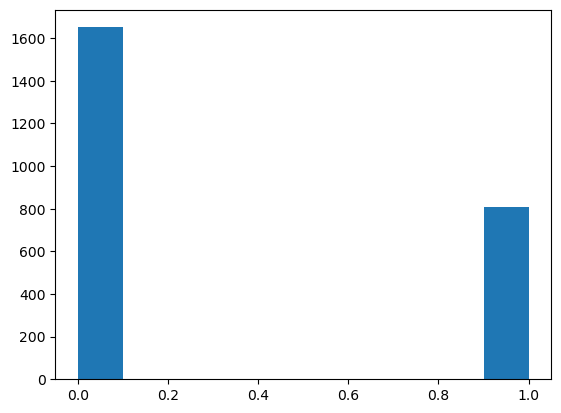

In [334]:
_ = plt.hist(train_clusters)

In [335]:
class FullyConnectedReactionModel(torch.nn.Module):

    def __init__(
        self, 
        *, 
        input_dim, 
        hidden_dims, 
        target_dim,
        hidden_act, 
        output_act, 
        use_batchnorm, 
        dropout_prob
    ):
        super(FullyConnectedReactionModel, self).__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(torch.nn.Linear(prev_dim, dim))
            layers.append(hidden_act())
            if use_batchnorm:
                layers.append(torch.nn.BatchNorm1d(dim))
            if dropout_prob > 0:
                layers.append(torch.nn.Dropout(p=0.2))
            prev_dim = dim
        layers.append(torch.nn.Linear(prev_dim, target_dim))
        if output_act is torch.nn.Softmax:
            layers.append(output_act(dim=1))
        else:
            layers.append(output_act())
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x, training=True):

        if training:
            self.train()
        else:
            self.eval()

        return self.layers(x)



def train_loop(model, x_train, y_train, *, epochs, batch_size, loss_fn, optimizer, report_freq, train_cluster_ids_for_downstream=None, train_similarity_dist=None, x_val=None, y_val=None, val_cluster_ids_for_downstream=None, val_similarity_dist=None):
    
    report_epochs = []
    train_loss_trajectory = []
    val_loss_trajectory = []

    if report_freq and (x_val is not None) and (y_val is not None):
        # if we are reporting the validation data should exist
        if train_cluster_ids_for_downstream is not None:
            assert val_cluster_ids_for_downstream is not None

        if train_similarity_dist is not None:
            assert val_similarity_dist is not None

    idxes = np.arange(x_train.shape[0])
    for e in (t := trange(epochs, desc='', leave=True)):
        np.random.shuffle(idxes)
        batch_idxes = idxes[:int(x_train.shape[0] * batch_size)]
        if train_cluster_ids_for_downstream is None:
            pred_train = model(x_train[batch_idxes], training=True)
        else:
            pred_train = model(x_train[batch_idxes], train_cluster_ids_for_downstream[batch_idxes], training=True)
        if train_similarity_dist == None:
            loss = loss_fn(pred_train, y_train[batch_idxes])
        else:
            loss = loss_fn(pred_train, y_train[batch_idxes], train_similarity_dist[batch_idxes])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if report_freq:
            if e % report_freq == 0:
                verbose_str = f"Epoch: {e} train loss: {loss.detach().numpy().item()}"
                report_epochs.append(e)
                train_loss_trajectory.append(loss.detach().numpy().item())

                if (x_val is not None) and (y_val is not None):

                    if val_cluster_ids_for_downstream is None:
                        pred_val = model(x_val, training=False)
                    else:
                        pred_val = model(x_val, val_cluster_ids_for_downstream, training=False)
                    if val_similarity_dist == None:
                        loss_val = loss_fn(pred_val, y_val)
                    else:
                        loss_val = loss_fn(pred_val, y_val, val_similarity_dist)

                    val_loss_trajectory.append(loss_val.detach().numpy().item())
                    verbose_str += f" val loss: {loss_val.detach().numpy().item()} "
                t.set_description(verbose_str, refresh=True)

    if val_loss_trajectory:
        return pd.DataFrame({"train_loss": train_loss_trajectory, "val_loss": val_loss_trajectory}, index=report_epochs)
    else:
        return pd.DataFrame({"train_loss": train_loss_trajectory}, index=report_epochs)


In [336]:
# A data through one model for all reactions
# rxn_diff_fp width -> ohe width

x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)
fcrm = FullyConnectedReactionModel(
    input_dim=x_train.shape[1],
    hidden_dims=[100,100],
    target_dim=y_train.shape[1],
    hidden_act=torch.nn.ReLU, 
    output_act=torch.nn.Softmax, 
    use_batchnorm=True, 
    dropout_prob=0.1,
)
hist = train_loop(fcrm, x_train, y_train, epochs=1000, batch_size=0.5, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=torch.optim.SGD(fcrm.parameters(), lr=1e-4), report_freq=1, x_val=x_val, y_val=y_val)

Epoch: 999 train loss: 5.062797546386719 val loss: 5.062538146972656 : 100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s] 


<AxesSubplot:title={'center':'All Data'}>

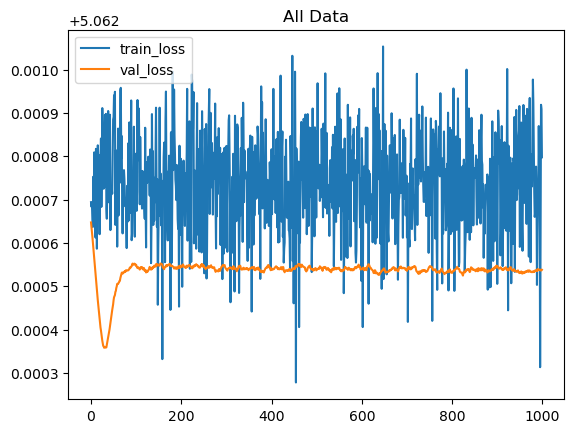

In [337]:
hist.plot(title="All Data")

In [338]:
# Data through one model per reaction cluster
# rxn_diff_fp width -> ohe width

train_clusters = Kmean.predict(rxn_diff_fp_train)
val_clusters = Kmean.predict(rxn_diff_fp_val)

cluster_models = {}
cluster_histories = {}

for cluster in np.unique(train_clusters):
    x_train = torch.Tensor(rxn_diff_fp_train[train_clusters == cluster])
    y_train = torch.Tensor(reag1_ohe_train[train_clusters == cluster])
    x_val = torch.Tensor(rxn_diff_fp_val[val_clusters == cluster])
    y_val = torch.Tensor(reag1_ohe_val[val_clusters == cluster])
    fcrm = FullyConnectedReactionModel(
        input_dim=x_train.shape[1],
        hidden_dims=[100,100],
        target_dim=y_train.shape[1],
        hidden_act=torch.nn.ReLU, 
        output_act=torch.nn.Softmax, 
        use_batchnorm=True, 
        dropout_prob=0.1,
    )
    optimizer = torch.optim.SGD(fcrm.parameters(), lr=1e-4)
    loss_fn = torch.nn.CrossEntropyLoss()

    hist = train_loop(fcrm, x_train, y_train, epochs=1000, batch_size=0.5, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=torch.optim.SGD(fcrm.parameters(), lr=1e-4), report_freq=1, x_val=x_val, y_val=y_val)
    cluster_models[cluster] = fcrm
    cluster_histories[cluster] = hist

Epoch: 999 train loss: 5.062810897827148 val loss: 5.062595844268799 : 100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s] 
Epoch: 999 train loss: 5.062624931335449 val loss: 5.063063621520996 : 100%|██████████| 1000/1000 [01:31<00:00, 10.94it/s] 


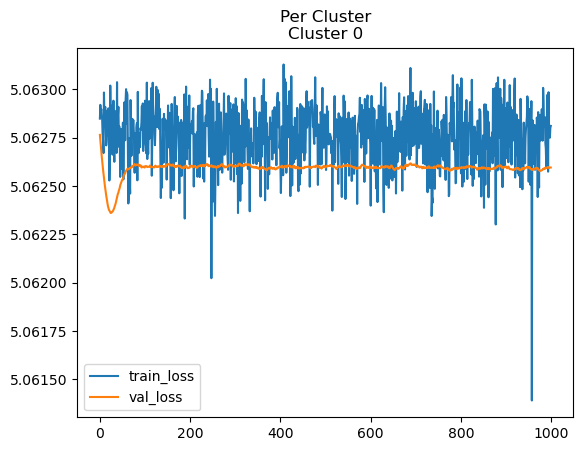

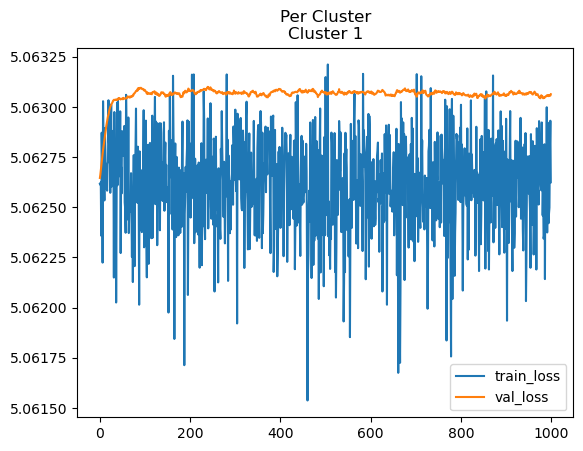

In [339]:
for cluster in np.unique(train_clusters):
    cluster_histories[cluster].plot(title=f"Per Cluster\nCluster {cluster}")
    plt.show()

In [340]:
# Shared upstream layers but then downstream they become cluster specific

# we can either have the model train the clusters at the same time or one after the other (in single epoch steps)
# TODO I am unsure how the gradient graph will be built if trained at the same time

class SharedUpstreamReactionModel(torch.nn.Module):

    def __init__(
        self, 
        *,
        num_clusters, 
        input_dim, 
        hidden_dims,
        target_dim, 
        hidden_act, 
        output_act, 
        use_batchnorm, 
        dropout_prob,
        downstream_input_dim,
        downstream_hidden_dims,
        downstream_hidden_act, 
        downstream_output_act, 
        downstream_use_batchnorm, 
        downstream_dropout_prob,
    ):
        super(SharedUpstreamReactionModel, self).__init__()

        self.target_dim = target_dim

        self.shared_upstream = FullyConnectedReactionModel(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            target_dim=downstream_input_dim,
            hidden_act=hidden_act, 
            output_act=output_act, 
            use_batchnorm=use_batchnorm, 
            dropout_prob=dropout_prob,
        )

        self.downstream_models = {}
        for c in range(num_clusters):
            self.downstream_models[c] = FullyConnectedReactionModel(
                input_dim=downstream_input_dim,
                hidden_dims=downstream_hidden_dims,
                target_dim=target_dim,
                hidden_act=downstream_hidden_act, 
                output_act=downstream_output_act, 
                use_batchnorm=downstream_use_batchnorm, 
                dropout_prob=downstream_dropout_prob,
            )

    def forward(self, x, cluster_ids, training=True):
        shared_output = self.shared_upstream(x, training=training)
        output = torch.zeros(shared_output.shape[0], self.target_dim)

        for c in np.unique(cluster_ids):
            cluster_model_output = self.downstream_models[c](shared_output[cluster_ids == c], training=training)
            output[cluster_ids == c] = cluster_model_output
        return output

In [341]:
train_clusters = Kmean.predict(rxn_diff_fp_train)
val_clusters = Kmean.predict(rxn_diff_fp_val)
x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)


surm = SharedUpstreamReactionModel(
    num_clusters=len(np.unique(train_clusters)), 
    input_dim=x_train.shape[1], 
    hidden_dims=[10,10],
    target_dim=y_train.shape[1], 
    hidden_act=torch.nn.ReLU, 
    output_act=torch.nn.ReLU, 
    use_batchnorm=True, 
    dropout_prob=0.1,
    downstream_input_dim=100,
    downstream_hidden_dims=[10,10],
    downstream_hidden_act=torch.nn.ReLU, 
    downstream_output_act=torch.nn.Softmax, 
    downstream_use_batchnorm=True, 
    downstream_dropout_prob=0.1,
)

hist = train_loop(surm, x_train, y_train, epochs=1000, batch_size=0.5, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=torch.optim.SGD(surm.parameters(), lr=1e-4), report_freq=1, train_cluster_ids_for_downstream=train_clusters, x_val=x_val, y_val=y_val, val_cluster_ids_for_downstream=val_clusters)

Epoch: 999 train loss: 5.062146186828613 val loss: 5.0620880126953125 : 100%|██████████| 1000/1000 [00:39<00:00, 25.39it/s]


<AxesSubplot:title={'center':'Shared Upstream'}>

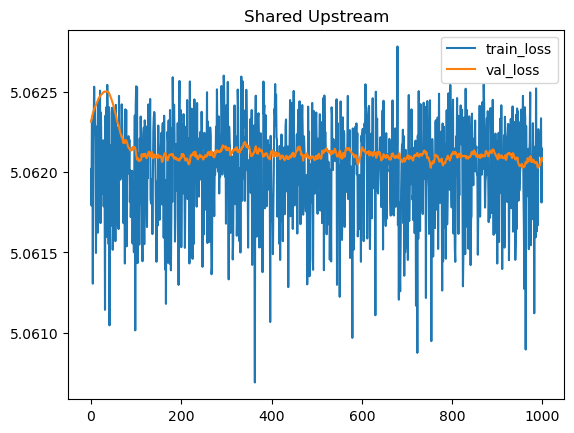

In [342]:
hist.plot(title="Shared Upstream")

In [343]:
# Data through one model per reaction cluster but we scale the gradient based on the distance to the cluster, this is not parameter sharing but is infact a form of label smoothing

# rxn_diff_fp width -> ohe width
# we end up here with 10 valid models so we can either ensemble or just predict based on the which cluster is most near


In [344]:
def similarity_CrossEntropyLoss(y_pred, y_true, dist):
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    return torch.mean(loss_fn(y_pred, y_true) * dist)

cluster_models = {}
cluster_histories = {}

x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)
train_dist = torch.nn.Softmax(dim=1)(torch.Tensor(Kmean.transform(rxn_diff_fp_train)))
val_dist = torch.nn.Softmax(dim=1)(torch.Tensor(Kmean.transform(rxn_diff_fp_val)))

for cluster in np.unique(train_clusters):
    fcrm = FullyConnectedReactionModel(
        input_dim=x_train.shape[1],
        hidden_dims=[100,100],
        target_dim=y_train.shape[1],
        hidden_act=torch.nn.ReLU, 
        output_act=torch.nn.Softmax, 
        use_batchnorm=True, 
        dropout_prob=0.1,
    )
    cluster_models[cluster] = fcrm

    hist = train_loop(fcrm, x_train, y_train, epochs=1000, batch_size=0.5, loss_fn = similarity_CrossEntropyLoss, optimizer = torch.optim.SGD(fcrm.parameters(), lr=1e-4), report_freq=1, train_similarity_dist=train_dist[:, cluster], x_val=x_val, y_val=y_val, val_similarity_dist=val_dist[:, cluster])
    cluster_histories[cluster] = hist

Epoch: 999 train loss: 1.6370363235473633 val loss: 1.5419830083847046 : 100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]
Epoch: 999 train loss: 3.5183064937591553 val loss: 3.5210087299346924 : 100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]


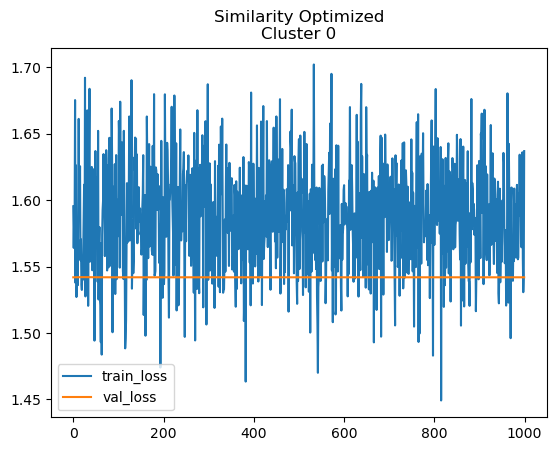

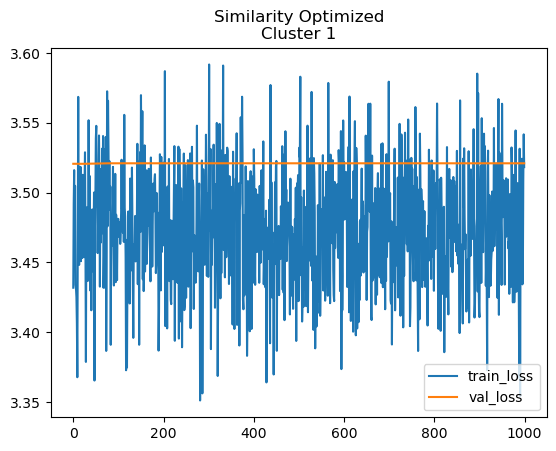

In [345]:
for cluster in np.unique(train_clusters):
    cluster_histories[cluster].plot(title=f"Similarity Optimized\nCluster {cluster}")
    plt.show()